# Initializing

In [242]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
import comet_ml
import os
import torch
from torch.utils.data import DataLoader
from pathlib import Path

from src.utils.coco import COCODataset
from src.utils.pretty_print import *
from src.models import get_model_maskrcnn
from src.utils.train import maskrcnn_training_testing_loop
from src.utils.comet import CometLogger
from dotenv import load_dotenv

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 42

# for reproducibility
torch.manual_seed(SEED)

# Datasets

## COCO Datasets

In [244]:
slide_path = Path("/storage01/bolma/dev/data/datasets/WSI-ROI/slides/l6/annotations.json")

In [245]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(0.5),
    A.VerticalFlip(0.5),
    A.ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))


In [246]:
train_dataset = COCODataset(
    annotation_file=slide_path,
    train=True,
    transform=None,
    random_seed=SEED,
    bbox_format='pascal_voc'
)

test_dataset = COCODataset(
    annotation_file=slide_path,
    train=False,
    transform=None,
    random_seed=SEED,
    bbox_format='pascal_voc'
)

# Checks
train_images = set(id for id in train_dataset.image_ids)
test_images = set(id for id in test_dataset.image_ids)

print(f"Training image id-s: \t{train_images}")
print(f"\nTest image id-s: \t{test_images}")

# Overlapping images between datasets
overlapping_images = train_images.intersection(test_images)

if overlapping_images:
    print("\n[WARNING]: Overlapping images found:")
    for img in overlapping_images:
        print(f"- {img}")
else:
    print_success("Datasets are properly split and ready to use!")



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded training set with 41 images

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded test set with 11 images

Training image id-s: 	{0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 44, 45, 46, 48, 49, 51}

Test image id-s: 	{32, 3, 5, 41, 43, 12, 13, 47, 17, 50, 19}

✅ Datasets are properly split and ready to use!


### Visualization

Training Dataset Examples:
Image index: 40 (Image ID: 38)


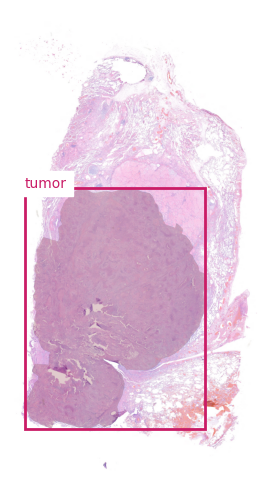

Image index: 28 (Image ID: 35)


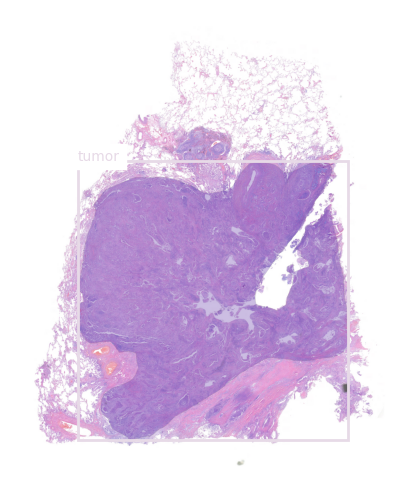

In [247]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from matplotlib.patches import Rectangle

def visualize_coco_samples(dataset, num_samples=3, indices=None, figsize=(15, 5), 
                          show_masks=True, show_boxes=True, show_labels=True,
                          mask_alpha=0.3, random_color=True):
    """
    Visualizes samples from COCO dataset with annotations.
    """
    if indices is None:
        # Get random indices
        indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for idx in indices:
        print(f"Image index: {idx} (Image ID: {dataset.image_ids[idx]})")
        image, target = dataset[idx]
        
        # If image is a tensor, convert to numpy array for visualization
        if isinstance(image, torch.Tensor):
            img = image.cpu().numpy().transpose(1, 2, 0)
            # Use consistent scaling - divide by 255 instead of min-max normalization
            img = img / 255.0
            # Clip to valid range
            img = np.clip(img, 0, 1)
        else:
            img = np.array(image) / 255.0
        
        # Create figure and axes
        fig, ax = plt.subplots(figsize=figsize)
        
        # Display image
        ax.imshow(img)
        
        # Get masks, boxes, and labels from target
        masks = target['masks']
        boxes = target['boxes']
        labels = target['labels']
        
        # Create a single combined overlay for all masks
        if show_masks and len(masks) > 0:
            # Initialize combined overlay
            h, w = masks[0].shape if len(masks) > 0 else img.shape[:2]
            combined_overlay = np.zeros((h, w, 4))  # RGBA image for overlay
            
            for i in range(len(masks)):
                if i < len(masks):
                    # Generate color for this instance
                    if random_color:
                        color = np.random.rand(3)
                    else:
                        cmap = plt.cm.get_cmap('tab10')
                        color = cmap(labels[i] % 10)[:3]
                    
                    # Add this mask to the combined overlay
                    mask = masks[i].cpu().numpy()
                    combined_overlay[mask == 1, :3] = color
                    combined_overlay[mask == 1, 3] = mask_alpha  # Set alpha channel
            
            # Apply the combined overlay
            ax.imshow(combined_overlay)
        
        # Display bounding boxes and labels
        for i in range(len(boxes)):
            # Generate color for this instance
            if random_color:
                color = np.random.rand(3)
            else:
                cmap = plt.cm.get_cmap('tab10')
                color = cmap(labels[i] % 10)[:3]
            
            # Display bounding box if requested
            if show_boxes and i < len(boxes):
                box = boxes[i].cpu().numpy()
                x1, y1, x2, y2 = box
                width = x2 - x1
                height = y2 - y1
                rect = Rectangle((x1, y1), width, height, 
                                linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                
                # Display category label if requested
                if show_labels:
                    category_id = labels[i].item()
                    category_name = dataset.categories.get(category_id, str(category_id))
                    ax.text(x1, y1-5, category_name, color=color, 
                           fontsize=10, backgroundcolor='white')
        
        ax.axis('off')
        plt.tight_layout()
        plt.show()

print("Training Dataset Examples:")
visualize_coco_samples(train_dataset, num_samples=2)

## Dataloaders

In [248]:
BATCH_SIZE = 1
NUM_WORKERS = 8

In [249]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    #collate_fn=lambda x: tuple(zip(*x))  # To handle variable size images/masks
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    #collate_fn=lambda x: tuple(zip(*x))
)

print_info(f"Created DataLoaders with batch size {BATCH_SIZE}")
print(f"\t- Training batches: {len(train_dataloader)}")
print(f"\t- Test batches: {len(test_dataloader)}")


ℹ️ Created DataLoaders with batch size 1
	- Training batches: 41
	- Test batches: 11


# Training

## Model architecture

In [252]:
from src.models import get_model_maskrcnn_with_groupnorm

maskrcnn = get_model_maskrcnn_with_groupnorm(num_classes=2, 
                      box_score_thresh=0.1,
                      box_nms_thresh=0.3,
                      box_fg_iou_thresh=0.5,
                      box_bg_iou_thresh=0.4,
                      box_detections_per_img=10,
                      image_mean = [0.485, 0.456, 0.406],
                      image_std = [0.229, 0.224, 0.225])

optimizer = torch.optim.SGD(maskrcnn.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)

## Training loop

In [253]:
import warnings

# For logging to comet.ml, a cloud service
load_dotenv()
api_key = os.getenv('COMET_API_KEY')
comet_logger = CometLogger(api_key=api_key,
                        project_name="msc-thesis",
                        experiment_name="MaskRCNN",
                        log_env_details=False,)

# Supressing some warning coming from a library with legacy code
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Creating a tensor from a list of numpy.ndarrays is extremely slow.')
    # Training loop
    maskrcnn_training_testing_loop(maskrcnn,device, train_dataloader, test_dataloader, optimizer, scheduler, n_epochs=30, box_score_thresh=0.5, comet_logger=comet_logger)


# Save some sample images with predictions to comet.ml
with torch.set_grad_enabled(False):
    comet_logger.upload_images(
        model = maskrcnn,
        device = device,
        dataloader = test_dataloader,
        confidence_thr = 0.5,
        entry_name = "sample_img",
        overwrite = True,
        indices = [0,1,2],
    )

comet_logger.end() # End the comet logger session

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml CometLogger Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : MaskRCNN
COMET INFO:     url                   : https://www.comet.com/bolf-marton/msc-thesis/c6ec518fd96b49e3945415d0ad9e0a85
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     iou [14]           : (0.3045278840901109, 0.54146866726841)
COMET INFO:     learning_rate      : 0.01
COMET INFO:     loss [61]          : (0.25594887137413025, 6.58884859085083)
COMET INFO:     test_loss [14]     : (1.1140151023864746, 1.6114391088485718)
COMET INFO:     training_loss [14] : (0.7333630323410034, 1.8292150497436523)
COMET INFO:   Others:
COMET INFO:     Name : MaskRCNN
COMET INFO:   Uploads:
COMET INFO:     filename                 : 1
COMET INFO:    


🚀 STARTING TRAINING
---------------------
Epoch 1/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:18<00:00,  2.19it/s]


Train – Mean Loss: 2.1150


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Test – IoU: 0.2580, Loss: 1.4774
---------------------
Epoch 2/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:25<00:00,  1.63it/s]


Train – Mean Loss: 1.8029


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Test – IoU: 0.2980, Loss: 1.4764
---------------------
Epoch 3/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:25<00:00,  1.62it/s]


Train – Mean Loss: 1.6342


100%|██████████| 11/11 [00:12<00:00,  1.09s/it]


Test – IoU: 0.4011, Loss: 1.2240
---------------------
Epoch 4/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:26<00:00,  1.55it/s]


Train – Mean Loss: 1.4266


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Test – IoU: 0.3680, Loss: 1.2040
---------------------
Epoch 5/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:27<00:00,  1.49it/s]


Train – Mean Loss: 1.4267


100%|██████████| 11/11 [00:11<00:00,  1.09s/it]


Test – IoU: 0.3856, Loss: 1.1602
---------------------
Epoch 6/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:25<00:00,  1.58it/s]


Train – Mean Loss: 1.3991


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Test – IoU: 0.4381, Loss: 1.1635
---------------------
Epoch 7/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:24<00:00,  1.70it/s]


Train – Mean Loss: 1.3097


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Test – IoU: 0.4556, Loss: 1.0781
---------------------
Epoch 8/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:26<00:00,  1.54it/s]


Train – Mean Loss: 1.2512


100%|██████████| 11/11 [00:11<00:00,  1.09s/it]


Test – IoU: 0.4267, Loss: 1.1376
---------------------
Epoch 9/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:29<00:00,  1.37it/s]


Train – Mean Loss: 1.2998


100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


Test – IoU: 0.4637, Loss: 1.1345
----------------------
Epoch 10/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:24<00:00,  1.65it/s]


Train – Mean Loss: 1.2265


100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Test – IoU: 0.4531, Loss: 1.1187
----------------------
Epoch 11/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:22<00:00,  1.79it/s]


Train – Mean Loss: 1.1917


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Test – IoU: 0.4864, Loss: 1.0986
----------------------
Epoch 12/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:29<00:00,  1.37it/s]


Train – Mean Loss: 1.1714


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Test – IoU: 0.4232, Loss: 1.0656
----------------------
Epoch 13/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:28<00:00,  1.44it/s]


Train – Mean Loss: 1.1756


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Test – IoU: 0.4581, Loss: 1.1434
----------------------
Epoch 14/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:31<00:00,  1.29it/s]


Train – Mean Loss: 1.2224


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Test – IoU: 0.4498, Loss: 1.1720
----------------------
Epoch 15/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:25<00:00,  1.62it/s]


Train – Mean Loss: 1.2211


100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


Test – IoU: 0.4413, Loss: 1.1629
----------------------
Epoch 16/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:25<00:00,  1.58it/s]


Train – Mean Loss: 1.1892


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Test – IoU: 0.3992, Loss: 1.1986
----------------------
Epoch 17/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:29<00:00,  1.38it/s]


Train – Mean Loss: 1.1559


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Test – IoU: 0.4481, Loss: 1.1124
----------------------
Epoch 18/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Train – Mean Loss: 1.1324


100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


Test – IoU: 0.4507, Loss: 1.2103
----------------------
Epoch 19/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:21<00:00,  1.88it/s]


Train – Mean Loss: 1.1339


100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


Test – IoU: 0.4472, Loss: 1.1129
----------------------
Epoch 20/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:24<00:00,  1.70it/s]


Train – Mean Loss: 1.0864


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Test – IoU: 0.4439, Loss: 1.1888
----------------------
Epoch 21/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:30<00:00,  1.34it/s]


Train – Mean Loss: 1.0886


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Test – IoU: 0.4304, Loss: 1.2210
----------------------
Epoch 22/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:25<00:00,  1.62it/s]


Train – Mean Loss: 1.0540


100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


Test – IoU: 0.4241, Loss: 1.2730
----------------------
Epoch 23/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:20<00:00,  1.99it/s]


Train – Mean Loss: 1.0072


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Test – IoU: 0.4495, Loss: 1.2145
----------------------
Epoch 24/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:26<00:00,  1.52it/s]


Train – Mean Loss: 0.9626


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Test – IoU: 0.4443, Loss: 1.1474
----------------------
Epoch 25/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:23<00:00,  1.71it/s]


Train – Mean Loss: 0.9452


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


Test – IoU: 0.4322, Loss: 1.2167
----------------------
Epoch 26/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:28<00:00,  1.44it/s]


Train – Mean Loss: 0.9503


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Test – IoU: 0.4311, Loss: 1.1857
----------------------
Epoch 27/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:22<00:00,  1.85it/s]


Train – Mean Loss: 0.9339


100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


Test – IoU: 0.4477, Loss: 1.1768
----------------------
Epoch 28/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:29<00:00,  1.40it/s]


Train – Mean Loss: 0.9273


100%|██████████| 11/11 [00:12<00:00,  1.09s/it]


Test – IoU: 0.4654, Loss: 1.1560
----------------------
Epoch 29/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:24<00:00,  1.70it/s]


Train – Mean Loss: 0.9210


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Test – IoU: 0.4604, Loss: 1.1915
----------------------
Epoch 30/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:28<00:00,  1.46it/s]


Train – Mean Loss: 0.9219


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Test – IoU: 0.4433, Loss: 1.1772


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml CometLogger Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : MaskRCNN
COMET INFO:     url                   : https://www.comet.com/bolf-marton/msc-thesis/14ad2455d861499dae5ecc1314ccf369
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     iou [30]           : (0.25797406232738057, 0.4863510725330665)
COMET INFO:     learning_rate [30] : (0.001, 0.01)
COMET INFO:     loss [123]         : (0.43114063143730164, 2.7271509170532227)
COMET INFO:     test_loss [30]     : (1.0655618906021118, 1.4773520231246948)
COMET INFO:     training_loss [30] : (0.9209789633750916, 2.1149742603302)
COMET INFO:   Others:
COMET INFO:     Name : MaskRCNN
COMET INFO:   Uploads:
COMET INFO:     filename                 : 1
COME

In [254]:
# Save the model weights
torch.save(maskrcnn.state_dict(), "src/models/weights/MaskRCNN_trained_weights.pth")